# House Prices - EDA

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

PROJECT_PATH = "/".join(os.getcwd().split('/')[:-1])
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train.csv')

# Load the training dataset
house_prices_train = pd.read_csv(TRAIN_DATA_PATH)
house_prices_train = house_prices_train.drop('Id', axis=1)
house_prices_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Looking at the missing values

In [3]:
# Get the columns from the dataset
cols = house_prices_train.columns.tolist()

print('-------------------------')
print('Columns with missing data')
print('-------------------------')

cols_with_missing_data = []

# For each column, find the ratio of missing data
for col in cols:
    col_data = house_prices_train[col]
    missing_rows = len(col_data[col_data.isna()])
    total_rows = len(col_data)
    missing_ratio = (missing_rows / total_rows)
    
    # Anything greater than 0.0 if missing a value
    if missing_ratio > 0.0:
        cols_with_missing_data.append(col)
        print('{:16} {:.2f}%'.format(col, missing_ratio * 100))

print('-------------------------')
print('{} columns contain missing values'.format(len(cols_with_missing_data)))

-------------------------
Columns with missing data
-------------------------
LotFrontage      17.74%
Alley            93.77%
MasVnrType       0.55%
MasVnrArea       0.55%
BsmtQual         2.53%
BsmtCond         2.53%
BsmtExposure     2.60%
BsmtFinType1     2.53%
BsmtFinType2     2.60%
Electrical       0.07%
FireplaceQu      47.26%
GarageType       5.55%
GarageYrBlt      5.55%
GarageFinish     5.55%
GarageQual       5.55%
GarageCond       5.55%
PoolQC           99.52%
Fence            80.75%
MiscFeature      96.30%
-------------------------
19 columns contain missing values


Out of the 80 features we have in the dataset, 19 of them have missing data in some form.

In [4]:
house_prices_train[cols_with_missing_data].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   Alley         91 non-null     object 
 2   MasVnrType    1452 non-null   object 
 3   MasVnrArea    1452 non-null   float64
 4   BsmtQual      1423 non-null   object 
 5   BsmtCond      1423 non-null   object 
 6   BsmtExposure  1422 non-null   object 
 7   BsmtFinType1  1423 non-null   object 
 8   BsmtFinType2  1422 non-null   object 
 9   Electrical    1459 non-null   object 
 10  FireplaceQu   770 non-null    object 
 11  GarageType    1379 non-null   object 
 12  GarageYrBlt   1379 non-null   float64
 13  GarageFinish  1379 non-null   object 
 14  GarageQual    1379 non-null   object 
 15  GarageCond    1379 non-null   object 
 16  PoolQC        7 non-null      object 
 17  Fence         281 non-null    object 
 18  MiscFeature   54 non-null   

Out of these 19 features, 3 of them are numeric features whilst the remaining 16 are categorical features.

In [5]:
def get_feature_count_by_types(dtypes=None):
    if dtypes is None:
        raise ValueError('dtypes needs to be provided')
    return len(house_prices_train.select_dtypes(dtypes).columns)

numeric_col_count = get_feature_count_by_types(['int64', 'float64'])
object_col_count = get_feature_count_by_types(['object'])

print('Number of numeric features: ', numeric_col_count)
print('Number of categorical features: ', object_col_count)

Number of numeric features:  37
Number of categorical features:  43


In [6]:
def get_data_by_dtypes(dtypes=None):
    if dtypes is None:
        raise ValueError('dtypes needs to be provided')
    return house_prices_train.select_dtypes(dtypes)

## Correlation Matrix

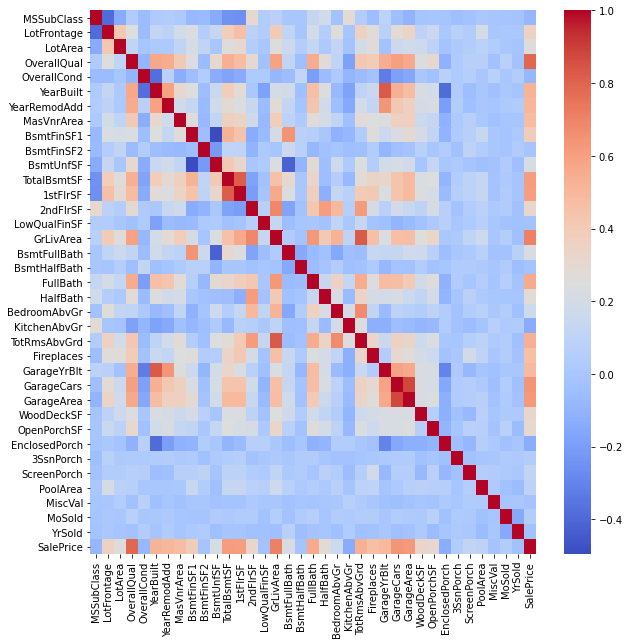

In [7]:
import seaborn as sns
corr = house_prices_train.corr()

%matplotlib inline

plt.figure(figsize=(10, 10))
sns.heatmap(corr, cmap='coolwarm')
plt.show()

Some keys correlations seen in the heatmap
 
Positive Correlations:
* Garage Cars - Garage Area
* Year built - Garage Year built
* TotRmsAbvGrd - GrlivArea
* 1stFirSF - TotalBsmtSF
* Sale Price - Overall Quality
* Sale Price - GrLivArea
* Sale Price - Garage Cars
* Sale Price - Garage Area
* BsmtFullBath - BsmFinSF1

Negative Correlation:
* BsmtFullBath - MsmtUnfSF
* Year Built - Enclosed Porch
* MsmtFinSF1 - BsmtUnfSF

## Reducing the number of features

In [8]:
cols_to_drop = []
cols = house_prices_train.columns.tolist()
for col in cols:
    col_data = house_prices_train[col]
    num_null_records = len(col_data[col_data.isna()])
    num_reocrds = len(col_data)
    missing_ratio = num_null_records / num_reocrds
    if missing_ratio >= 0.5:
        print('{:13} {:.2f}%'.format(col, missing_ratio * 100))
        cols_to_drop.append(col)

Alley         93.77%
PoolQC        99.52%
Fence         80.75%
MiscFeature   96.30%


In [9]:
# Remove all columns that are missing over 50% of thier data
reduce_train_data = house_prices_train.drop(cols_to_drop, axis=1)
reduce_train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [10]:
object_data = reduce_train_data.select_dtypes(['object'])
object_data.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


In [11]:
ordinal_cols = [
    'GarageCond',
    'GarageQual',
    'FireplaceQu',
    'KitchenQual',
    'HeatingQC',
    'BsmtFinType2', 
    'BsmtFinType1',
    'BsmtExposure',
    'BsmtCond',
    'BsmtQual',
    'ExterCond',
    'ExterQual']

In [12]:
nomial_data = object_data.drop(ordinal_cols, axis=1)
nomial_data

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Foundation,Heating,CentralAir,Electrical,Functional,GarageType,GarageFinish,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,PConc,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,CBlock,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,PConc,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,BrkTil,GasA,Y,SBrkr,Typ,Detchd,Unf,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,PConc,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,PConc,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,CBlock,GasA,Y,SBrkr,Min1,Attchd,Unf,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,Stone,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,CBlock,GasA,Y,FuseA,Typ,Attchd,Unf,Y,WD,Normal


In [13]:
# Remove any nomial columns that have a single value

nomial_data.nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
Foundation        6
Heating           6
CentralAir        2
Electrical        5
Functional        7
GarageType        6
GarageFinish      3
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

Every feature in the dataset has at least 2 categories, so we will keep all of these

https://machinelearningmastery.com/basic-data-cleaning-for-machine-learning/

In [14]:
# All the ordinal cols have more than 1 unique value
house_prices_train[ordinal_cols].nunique()

GarageCond      5
GarageQual      5
FireplaceQu     5
KitchenQual     4
HeatingQC       5
BsmtFinType2    6
BsmtFinType1    6
BsmtExposure    4
BsmtCond        4
BsmtQual        4
ExterCond       5
ExterQual       4
dtype: int64

## Create a basic pipeline to extract the relevant features based on the work so far

In [15]:
from sklearn.base import TransformerMixin

class FeatureExtractor(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.cols]

In [16]:
reduce_train_data = reduce_train_data.drop('SalePrice', axis=1)

In [17]:
numeric_cols = reduce_train_data.select_dtypes(['int64', 'float64']).columns.tolist()
nomial_cols = nomial_data.columns.tolist()

In [18]:
refined_phase1_cols = numeric_cols + nomial_cols + ordinal_cols

refined_phase1_data = house_prices_train[refined_phase1_cols]

Now we remove columns where there are less than 1% total unique numerical values from the features

In [19]:
refined_numerics = refined_phase1_data.select_dtypes(['int64', 'float64'])

cols_to_drop = []
for col in numeric_cols:
    unique_vals = refined_numerics[col].nunique()
    ratio = unique_vals / refined_numerics.shape[0] * 100
    if ratio > 5.0:
        print('{:15}: {:.2f}%'.format(col, ratio))
    else:
        cols_to_drop.append(col)

LotFrontage    : 7.53%
LotArea        : 73.49%
YearBuilt      : 7.67%
MasVnrArea     : 22.40%
BsmtFinSF1     : 43.63%
BsmtFinSF2     : 9.86%
BsmtUnfSF      : 53.42%
TotalBsmtSF    : 49.38%
1stFlrSF       : 51.58%
2ndFlrSF       : 28.56%
GrLivArea      : 58.97%
GarageYrBlt    : 6.64%
GarageArea     : 30.21%
WoodDeckSF     : 18.77%
OpenPorchSF    : 13.84%
EnclosedPorch  : 8.22%
ScreenPorch    : 5.21%


In [20]:
# Cols that have less than 5% of unique values in the dataset
cols_to_drop

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 '3SsnPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [21]:
refined_phase2_data = refined_phase1_data.drop(cols_to_drop, axis=1)
refined_phase2_data.head()

,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,FireplaceQu,KitchenQual,HeatingQC,BsmtFinType2,BsmtFinType1,BsmtExposure,BsmtCond,BsmtQual,ExterCond,ExterQual
0,65.0,8450,2003,196.0,706,0,150,856,856,854,...,NaN,Gd,Ex,Unf,GLQ,No,TA,Gd,TA,Gd
1,80.0,9600,1976,0.0,978,0,284,1262,1262,0,...,TA,TA,Ex,Unf,ALQ,Gd,TA,Gd,TA,TA
2,68.0,11250,2001,162.0,486,0,434,920,920,866,...,TA,Gd,Ex,Unf,GLQ,Mn,TA,Gd,TA,Gd
3,60.0,9550,1915,0.0,216,0,540,756,961,756,...,Gd,Gd,Gd,Unf,ALQ,No,Gd,TA,TA,TA
4,84.0,14260,2000,350.0,655,0,490,1145,1145,1053,...,TA,Gd,Ex,Unf,GLQ,Av,TA,Gd,TA,Gd


## Removing Highly Correlated Features

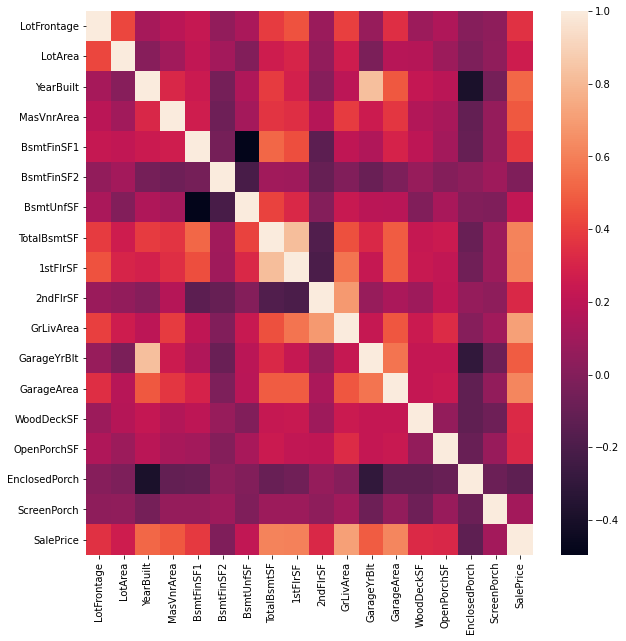

In [22]:
import seaborn as sns

# Add the target feature back
refined_phase2_data['SalePrice'] = house_prices_train.SalePrice

plt.figure(figsize=(10, 10))
sns.heatmap(refined_phase2_data.corr())
plt.show()

In [23]:
corr_matrix = refined_phase2_data.corr().abs()

# Select the upper half of the triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape)).astype(np.bool))

# Remove the diagonal
np.fill_diagonal(upper.values, 0)

# Remove the highly correlated features
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

[]

From plotting the correlation, there are no highly correlated features

Additionally, looking at the sale's price we can see some features that are correlated to it:

1. TotalBsmtSF
2. GrLiveArea
3. GarageArea
4. 1stFlrSF

## Visualising the refined dataset

In [24]:
# take a copy of the dataset
data = refined_phase2_data.copy()
data.head()

,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,KitchenQual,HeatingQC,BsmtFinType2,BsmtFinType1,BsmtExposure,BsmtCond,BsmtQual,ExterCond,ExterQual,SalePrice
0,65.0,8450,2003,196.0,706,0,150,856,856,854,...,Gd,Ex,Unf,GLQ,No,TA,Gd,TA,Gd,208500
1,80.0,9600,1976,0.0,978,0,284,1262,1262,0,...,TA,Ex,Unf,ALQ,Gd,TA,Gd,TA,TA,181500
2,68.0,11250,2001,162.0,486,0,434,920,920,866,...,Gd,Ex,Unf,GLQ,Mn,TA,Gd,TA,Gd,223500
3,60.0,9550,1915,0.0,216,0,540,756,961,756,...,Gd,Gd,Unf,ALQ,No,Gd,TA,TA,TA,140000
4,84.0,14260,2000,350.0,655,0,490,1145,1145,1053,...,Gd,Ex,Unf,GLQ,Av,TA,Gd,TA,Gd,250000


### Understanding the SalePrice

In [81]:
sale_price = data['SalePrice']
sale_price.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Key things that we can see:

* Minimum sale price is 34,900 so there is no house that is given away for free
* The average housr price is 180,921
* This data is skewed significantly as the difference between the 75 percentile and the max is significnatly large

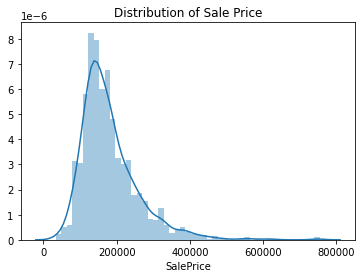

In [84]:
ax = sns.distplot(sale_price)
ax.set_title('Distribution of Sale Price')
plt.show()

Given the fact that target value is skewed, we can see that we have a few anomalies with the extreme values. We will need to decide how we should handle them.

## Some questions to answer:

* What is the average house like?
* What is the most expensive or cheapest house?

### Understand the average house

In [25]:
avg_house_price = data.SalePrice.mean()
print('Average Sale price: ${:.2f}'.format(avg_house_price))

Average Sale price: $180921.20


In [26]:
# +/- the average by 5000 dollars
min_avg_house_price = avg_house_price - 5000
max_avg_house_price = avg_house_price + 5000

avg_house_price_df = data[(data.SalePrice < max_avg_house_price) & (data.SalePrice > min_avg_house_price)]
avg_house_price_df.shape

(96, 57)

Looking at the house price over the years

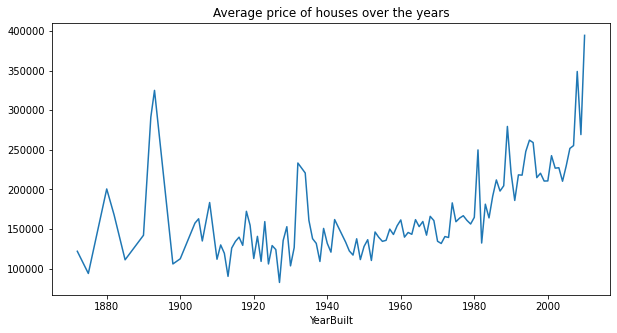

In [31]:
ax = data.groupby('YearBuilt')['SalePrice'].mean().plot(figsize=(10, 5))
ax.set_title('Average price of houses over the years')
plt.show()

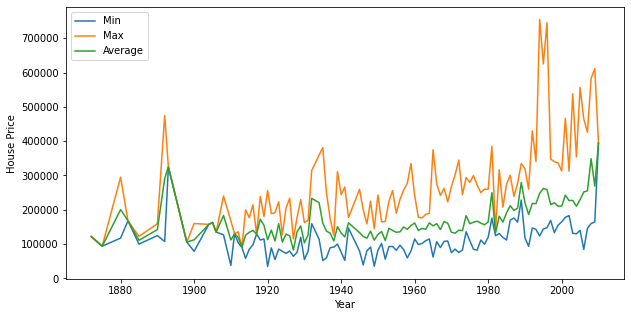

In [32]:
price_by_year = data.groupby('YearBuilt')['SalePrice']
years = price_by_year.max().index.tolist()
house_max = price_by_year.max().to_numpy()
house_min = price_by_year.min().to_numpy()
house_avg = price_by_year.mean().to_numpy()

plt.figure(figsize=(10, 5))
plt.plot(years, house_min, label='Min')
plt.plot(years, house_max, label='Max')
plt.plot(years, house_avg, label='Average')
plt.legend()
plt.xlabel('Year')
plt.ylabel('House Price')
plt.show()

Over the years, we can see that the sales price has steadily increased over the years. There has been a few spikes, one just during the, 1890s, during WW2 and 90s.

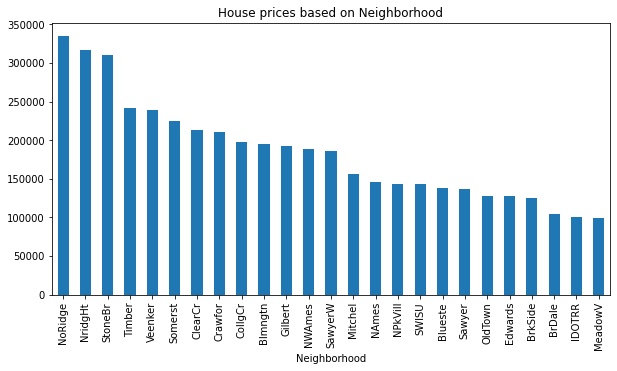

In [33]:
ax = data.groupby('Neighborhood')['SalePrice'].mean().sort_values()[::-1].plot(kind='bar', figsize=(10, 5))
ax.set_title('House prices based on Neighborhood')
plt.show()

We can clearly see that the neighbourhood the house is located will affect the final price. Indicating that some places are more sought after than others.

### Looking at the extreme cases

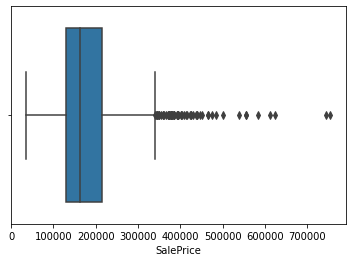

Number of outlier houses:  61


In [89]:
sale_price = data['SalePrice']
sns.boxplot(sale_price)
plt.show()

# Work out the interquartile range
q1 = sale_price.quantile(0.25)
q3 = sale_price.quantile(0.75)
iqr = Q3 - Q1

# Extracting those that are outside of the normal distribution
outlier_sale_price_df = data[(sale_price > (q3 + 1.5 * iqr))]
print("Number of outlier houses: ", outlier_sale_price_df.shape[0])

There are no outliers need the lower end of the data, but are a few high extreme cases

In [94]:
outlier_sale_price_df['SalePrice'].describe()

count        61.000000
mean     425954.180328
std       89557.255611
min      341000.000000
25%      372500.000000
50%      394617.000000
75%      440000.000000
max      755000.000000
Name: SalePrice, dtype: float64

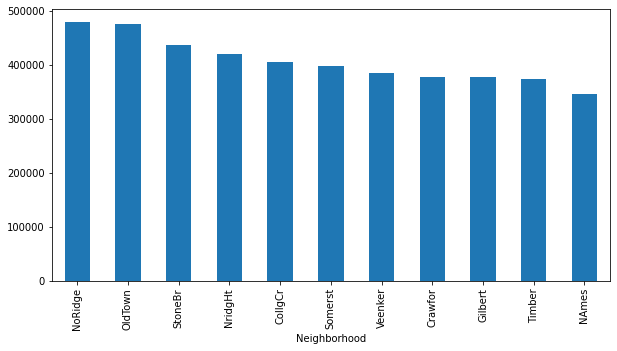

In [90]:
expensive_neighbourhoods = outlier_sale_price_df.groupby('Neighborhood')['SalePrice'].mean().sort_values()[::-1]
expensive_neighbourhoods.plot(kind='bar', figsize=(10, 5))
plt.show()

In [91]:
expensive_neighbourhoods.index.tolist()

['NoRidge',
 'OldTown',
 'StoneBr',
 'NridgHt',
 'CollgCr',
 'Somerst',
 'Veenker',
 'Crawfor',
 'Gilbert',
 'Timber',
 'NAmes']

From this, we have extract the neighbourhoods that are the most expensive to live in.

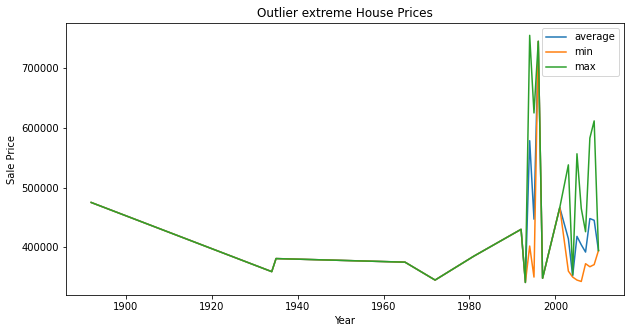

In [92]:
price_by_year = outlier_sale_price_df.groupby('YearBuilt')['SalePrice']
avg_price_by_year = price_by_year.mean()
min_price_by_year = price_by_year.min()
max_price_by_year = price_by_year.max()

plt.figure(figsize=(10, 5))
plt.plot(avg_price_by_year.index, avg_price_by_year, label='average')
plt.plot(min_price_by_year.index, min_price_by_year, label='min')
plt.plot(max_price_by_year.index, max_price_by_year, label='max')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sale Price')
plt.title('Outlier extreme House Prices')
plt.show()

We can see a steady increase over the years in the most expensive house prices. Between the 90s to the 2000s we can getting a few very extreme cases, which we may need to remove.

### Plotting the correlated features

As seen previously, we identified these features being correlated with `SalePrice`:

* TotalBsmtSF
* GrLiveArea
* GarageArea
* 1stFlrSF

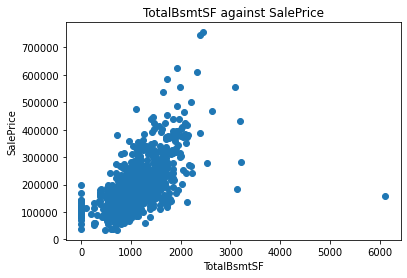

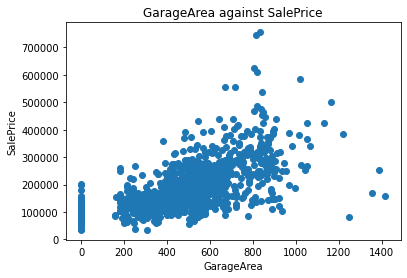

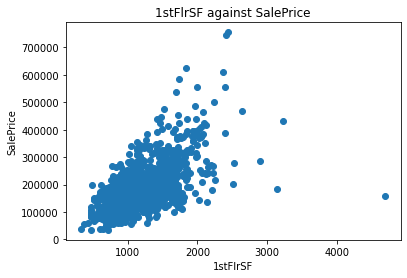

In [107]:
cols = ['TotalBsmtSF', 'GrLiveArea', 'GarageArea', '1stFlrSF']

missing_cols = []
for col in cols:
    try:
        col_data = data[col]
    except KeyError:
        missing_cols.append(col)
        continue
        
    plt.scatter(col_data, sale_price)
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    plt.title('{} against SalePrice'.format(col))
    plt.show()

In [106]:
# See if there were any missing cols
missing_cols

['GrLiveArea']

From the correlated columns, generally as the values increase for TotalBsmtSF, GarageArea & 1stFlrSF, the house price generally increases. 